In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense

from mydatools import img_plot

%matplotlib inline

Using Theano backend.
Using cuDNN version 5103 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)


In [2]:
# path = 'data/input/all/'
path = 'data/input/sample/'

In [3]:
def get_batches(dirname, gen=ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(224,224)):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, target_size=target_size)
    X = np.concatenate([batches.next()[0] for i in range(batches.samples)])
    y = np.concatenate([batches.next()[1] for i in range(batches.samples)])
    return X, y

def get_class(a_onehot):
    return a_onehot.argmax(axis=1)

## 图片展示

In [4]:
batches = get_batches(path+'train', shuffle=False, batch_size=4)
val_batches = get_batches(path+'val', shuffle=False, batch_size=4)

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


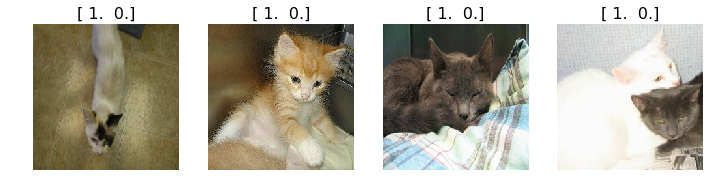

In [5]:
imgs, labels = next(batches)
img_plot.img_plots(imgs, titles=labels)

## VGG16 + Linear Model

使用VGG16对图片进行预测（这个时候，输出的类别有1000个，这是因为vgg本身是对1000各分类进行识别）

然后我们对vgg预测的结果进行一步线性模型的训练以及预测，将最终结果转化成2个分类（即猫和狗）

In [6]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.samples, nb_epoch=nb_epoch, 
                        validation_data=val_batches, nb_val_samples=val_batches.samples)

In [7]:
X_tra, y_tra = get_data(path+'train')
X_val, y_val = get_data(path+'val')

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [8]:
y_tra_class = get_class(y_tra)
y_val_class = get_class(y_val)

In [9]:
# vgg16
model = VGG16()
model.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# 使用vgg预测
vggres_tra = model.predict(X_tra)
vggres_val = model.predict(X_val)

In [11]:
# 可以看到预测的结果有1000个分类
vggres_tra.shape

(1800, 1000)

In [12]:
# 使用线性模型
lm = Sequential()
lm.add(Dense(2, input_shape=(1000,), activation='softmax'))
lm.compile(optimizer=RMSprop(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
lm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 2002      
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
_________________________________________________________________


In [14]:
lm.fit(vggres_tra, y_tra, batch_size=64, epochs=5, validation_data=(vggres_val, y_val))

Train on 1800 samples, validate on 200 samples
Epoch 1/5
1800/1800 [==============================] - 0s - loss: 0.5773 - acc: 0.9017 - val_loss: 0.5070 - val_acc: 0.9350
Epoch 2/5
1800/1800 [==============================] - 0s - loss: 0.4486 - acc: 0.9394 - val_loss: 0.4114 - val_acc: 0.9300
Epoch 3/5
1800/1800 [==============================] - 0s - loss: 0.3600 - acc: 0.9456 - val_loss: 0.3417 - val_acc: 0.9300
Epoch 4/5
1800/1800 [==============================] - 0s - loss: 0.2948 - acc: 0.9483 - val_loss: 0.2873 - val_acc: 0.9450
Epoch 5/5
1800/1800 [==============================] - 0s - loss: 0.2469 - acc: 0.9500 - val_loss: 0.2507 - val_acc: 0.9400


## View prediction result

In [15]:
pred_class = lm.predict_classes(vggres_val)
pred_proba = lm.predict_proba(vggres_val)

 32/200 [===>..........................] - ETA: 0s

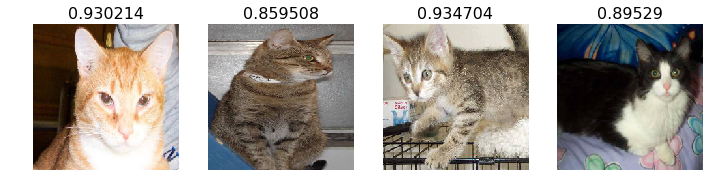

In [16]:
# 1. 展示正确的结果
cond = y_val_class == pred_class
show_imgs = X_val[cond][:4]
show_imgs_label = pred_proba[cond][:, 0][:4]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

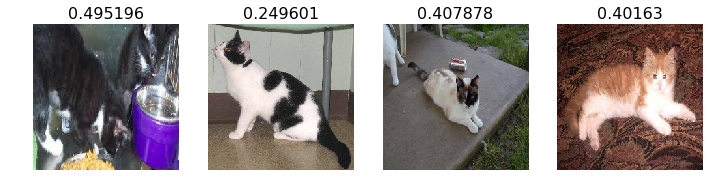

In [17]:
# 2. 展示错误的结果
cond = y_val_class != pred_class
show_imgs = X_val[cond][:4]
show_imgs_label = pred_proba[cond][:, 0][:4]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

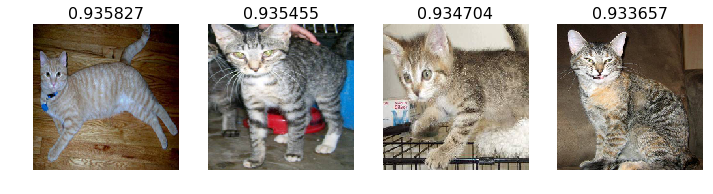

In [18]:
# 3. 展示最正确的结果
# 猫
class_id = 0
cond = (y_val_class == class_id) & (y_val_class == pred_class)
idx = pred_proba[cond][:, class_id].argsort()[::-1][:4]
show_imgs = X_val[cond][idx]
show_imgs_label = pred_proba[cond][idx][:, class_id]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

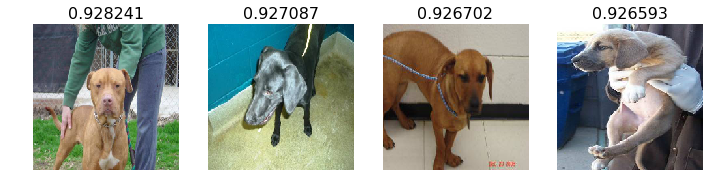

In [19]:
# 狗
class_id = 1
cond = (y_val_class == class_id) & (y_val_class == pred_class)
idx = pred_proba[cond][:, class_id].argsort()[::-1][:4]
show_imgs = X_val[cond][idx]
show_imgs_label = pred_proba[cond][idx][:, class_id]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

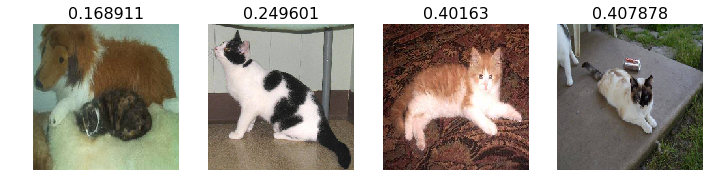

In [20]:
# 4. 展示最错误的结果
# 猫
class_id = 0
cond = (y_val_class == class_id) & (y_val_class != pred_class)
idx = pred_proba[cond][:, class_id].argsort()[:4]
show_imgs = X_val[cond][idx]
show_imgs_label = pred_proba[cond][idx][:, class_id]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

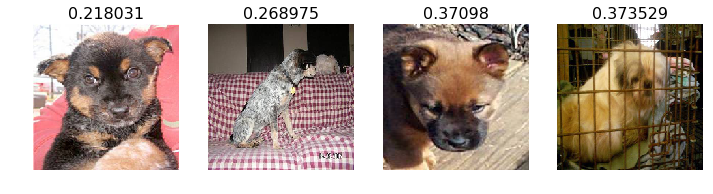

In [21]:
# 狗
class_id = 1
cond = (y_val_class == class_id) & (y_val_class != pred_class)
idx = pred_proba[cond][:, class_id].argsort()[:4]
show_imgs = X_val[cond][idx]
show_imgs_label = pred_proba[cond][idx][:, class_id]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

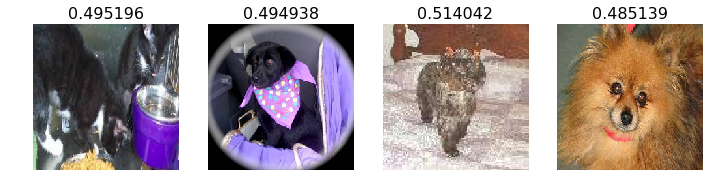

In [22]:
# 5. 最不确定的结果
idx = np.abs(pred_proba[:, 0] - 0.5).argsort()[:4]
show_imgs = X_val[idx]
show_imgs_label = pred_proba[idx][:, 0]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

In [23]:
model.layers

In [24]:
first_dense_idx = [index for index,layer in enumerate(model.layers) if type(layer) is Dense][0]

In [25]:
first_dense_idx

20

In [26]:
model.layers[20:]

## 预测

In [27]:
test_batches = get_batches(path+'test', shuffle=False, batch_size=1, class_mode=None)

Found 1000 images belonging to 1 classes.


In [28]:
vggres_test = model.predict_generator(test_batches, test_batches.samples)

In [29]:
test_prob = lm.predict(vggres_test)

In [30]:
res_df = pd.DataFrame({
    'id': [f[8:-4] for f in test_batches.filenames],
    'label': test_prob[:, batches.class_indices['dog']],
})

# 将label限制在0.05~0.95
res_df['label'] = res_df['label'].values.clip(min=0.05, max=0.95)

res_df.to_csv('./data/output/vgg16_finetune.csv', index=False)

In [31]:
from IPython.display import FileLink
FileLink('./data/output/vgg16_finetune.csv')

/home/ubuntu/nbs/MyKaggle/dogs-vs-cats-redux-kernels-edition/data/output/vgg16_finetune.csv

In [32]:
res_df['id'] = res_df['id'].apply(np.int)
res_df.sort_values('id')

,id,label
217,37,0.089531
665,38,0.146954
322,40,0.144106
537,43,0.897309
302,55,0.149941
77,90,0.585454
651,103,0.078751
842,104,0.065111
584,107,0.107635
753,111,0.896240
